## **Load Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import random

import cv2
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import imgaug.augmenters as iaa

## **Image Augmentation**

In [ ]:
# augmenter = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.Affine(
#         rotate=(-10, 10),
#         scale=(0.9, 1.1),
#         translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}
#     ),
#     iaa.AddToBrightness((-30, 30)),
#     iaa.contrast.LinearContrast(alpha=(0.8, 1.2)),
#     iaa.GaussianBlur(sigma=(0, 1.0)),
#     iaa.AdditiveGaussianNoise(scale=0.02*255)
# ])

# input_path = r"Face Dataset"
# output_path = r"Face Dataset"

# os.makedirs(output_path, exist_ok=True)

# for person in os.listdir(input_path):
#     p_in = os.path.join(input_path, person)
#     p_out = os.path.join(output_path, person)
#     os.makedirs(p_out, exist_ok=True)

#     for filename in os.listdir(p_in):
#         img = cv2.imread(os.path.join(p_in, filename))
#         for i in range(10):
#             aug = augmenter(image=img)
#             cv2.imwrite(os.path.join(p_out, f"{filename}_aug{i}.jpg"), aug)

## **Face Align & Cropping**

In [ ]:
import dlib
import cv2
import numpy as np

# Load detectors
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_81_face_landmarks.dat")

def align_face_dlib(image, desired_width=256, desired_height=256):
    """
    VERSI YANG LEBIH PERMISIF - DETEKSI LEBIH BANYAK WAJAH
    """
    
    if image is None or image.size == 0:
        return None
    
    # Convert to grayscale
    try:
        if len(image.shape) == 2:
            gray = image
        elif len(image.shape) == 3:
            if image.shape[2] == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            elif image.shape[2] == 4:
                gray = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
            else:
                return None
        else:
            return None
    except:
        return None
    
    if gray.dtype != np.uint8:
        gray = gray.astype(np.uint8)
    
    gray = np.ascontiguousarray(gray)
    
    # ============================================================
    # PERBAIKAN 1: TURUNKAN UPSAMPLING (LEBIH CEPAT & PERMISIF)
    # ============================================================
    try:
        faces = detector(gray, 0)  # ← UBAH DARI 1 KE 0
        # 0 = no upsampling (lebih cepat, deteksi lebih banyak)
        # 1 = upsample 1x (lebih lambat, lebih akurat tapi strict)
    except:
        return None
    
    if len(faces) == 0:
        return None
    
    # Pilih wajah terbesar
    face = max(faces, key=lambda rect: rect.width() * rect.height())
    
    # ============================================================
    # PERBAIKAN 2: SKIP ALIGNMENT, LANGSUNG CROP
    # (Untuk dataset yang sudah align seperti hasil augmentasi)
    # ============================================================
    
    # Ambil bounding box langsung
    x = face.left()
    y = face.top()
    w = face.width()
    h = face.height()
    
    # Padding
    PADDING = 0.25
    pad_w = int(w * PADDING)
    pad_h = int(h * PADDING)
    
    x = max(0, x - pad_w)
    y = max(0, y - pad_h)
    w = w + 2 * pad_w
    h = h + 2 * pad_h
    
    # Bounds check
    img_h, img_w = image.shape[:2]
    x2 = min(x + w, img_w)
    y2 = min(y + h, img_h)
    w = x2 - x
    h = y2 - y
    
    if w <= 0 or h <= 0:
        return None
    
    # Crop
    face_crop = image[y:y2, x:x2]
    
    if face_crop.size == 0:
        return None
    
    # Blur
    face_crop = cv2.GaussianBlur(face_crop, (3, 3), 0)
    
    # Brightness normalization
    try:
        yuv = cv2.cvtColor(face_crop, cv2.COLOR_BGR2YUV)
        yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
        face_crop = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    except:
        pass
    
    # Resize
    aligned_face = cv2.resize(face_crop, (desired_width, desired_height), 
                             interpolation=cv2.INTER_CUBIC)
    
    return aligned_face

## **Load Dataset**

In [ ]:
import cv2
import numpy as np
import os
import dlib
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler

# ==================== CONFIGURATION ====================
DATASET_PATH = r'C:\Users\nurul\Documents\ITTS Tugas Perkuliahan\Referensi img\project-learning\Face Dataset'
IMG_SIZE = (256, 256)  # Fixed size for all faces

# Initialize Dlib Face Detector (No .dat file needed)
detector = dlib.get_frontal_face_detector()
def extract_features(face_img):
    """Extracts HOG and LBP features from the face."""
    # 1. HOG Features (Shape/Edges)
    hog_feats = hog(face_img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    
    # 2. LBP Features (Texture)
    lbp = local_binary_pattern(face_img, P=24, R=3, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=26, range=(0, 26))
    lbp_feats = hist.astype("float")
    lbp_feats /= (lbp_feats.sum() + 1e-7) # Normalize
    
    # Combine them
    return np.concatenate([hog_feats, lbp_feats])

# ==================== MAIN PROCESSING ====================
X = [] # Features
y = [] # Labels (0, 1, 2...)
class_names = [] # Names ('Arina', 'Dani', etc.)

# Get list of subfolders (Classes)
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Folder not found: {DATASET_PATH}")

folders = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
print(f"Found classes: {folders}")

for label_id, folder_name in enumerate(folders):
    class_names.append(folder_name)
    folder_path = os.path.join(DATASET_PATH, folder_name)
    
    print(f"\nProcessing Folder: {folder_name} (Label: {label_id})")
    
    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
            
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        
        # 1. Detect & Crop
        face = get_face_crop(image)
        
        if face is not None:
            # 2. Extract Features
            feats = extract_features(face)
            
            X.append(feats)
            y.append(label_id)
            print(f"  [OK] {filename} processed.")
        else:
            print(f"  [XX] {filename} - No face detected.")

# ==================== FINAL DATA PREP ====================
X = np.array(X)
y = np.array(y)
groups = np.array(class_names)

scaler = StandardScaler()
X = scaler.fit_transform(X)

print("\n" + "="*40)
print("PROCESSING COMPLETE")
print(f"Total Images Processed: {len(X)}")
print(f"Feature Vector Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")
print("="*40)

Found classes: ['Arina', 'Dani', 'Shinta']

Processing Folder: Arina (Label: 0)
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug0.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug1.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug10.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug11.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug12.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug13.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug14.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug15.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug16.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug17.jpg processed.
  [OK] WhatsApp Image 2025-11-23 at 19.29.18 (1).jpeg_aug18.jpg processed.
  [OK] WhatsApp Image 2025-11-23

## **SVM Classification-to-Recognition**


TRAINING SVM CLASSIFIER
Total Samples: 310
Total Classes: 3
Classes found: ['Arina', 'Dani', 'Shinta']
Train Set: 217
Test Set:  93

🔍 Tuning Hyperparameters...
Fitting 10 folds for each of 4 candidates, totalling 40 fits

✅ Best Params: {'C': 5, 'kernel': 'rbf'}
✅ Best Score: 0.9958

FINAL EVALUATION
Test Accuracy: 97.85%

Classification Report:
              precision    recall  f1-score   support

       Arina       0.97      0.97      0.97        31
        Dani       1.00      0.96      0.98        24
      Shinta       0.97      1.00      0.99        38

    accuracy                           0.98        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.98      0.98      0.98        93



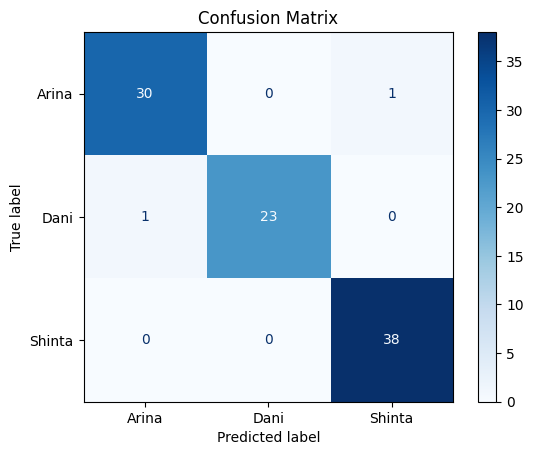


💾 Saving Model...
Files saved: face_recognition_model.pkl, face_recognition_model_scaler.pkl, face_recognition_model_labels.json


In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import json
import numpy as np

# ==================== CONFIGURATION ====================
MODEL_NAME = "face_recognition_model"

print("\n" + "=" * 80)
print("TRAINING SVM CLASSIFIER")
print("=" * 80)

# 1. Basic Validation
if len(X) == 0:
    raise ValueError("No data to train on! Check your dataset path.")

if len(np.unique(y)) < 2:
    raise ValueError(f"Need at least 2 classes to train. Found: {len(np.unique(y))}")

print(f"Total Samples: {len(X)}")
print(f"Total Classes: {len(class_names)}")
print(f"Classes found: {class_names}")

# 2. Split Data (80% Train, 20% Test)
# Stratify ensures we have a balanced mix of Arina/Dani/Shinta in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Train Set: {len(X_train)}")
print(f"Test Set:  {len(X_test)}")

# 3. Grid Search (Find Best Parameters)
print("\n🔍 Tuning Hyperparameters...")

param_grid = {
    'C': [5, 10, 15, 20],        # Regularization parameter
    'kernel': ['rbf'],   # Linear is usually faster, RBF often more accurate
}

# Use Stratified K-Fold for better reliability
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    SVC(gamma='scale', tol=1e-3, probability=True), 
    param_grid, 
    refit=True, 
    verbose=1, 
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print(f"\n✅ Best Params: {grid.best_params_}")
print(f"✅ Best Score: {grid.best_score_:.4f}")

# 4. Final Model Evaluation
final_model = grid.best_estimator_
y_pred = final_model.predict(X_test)

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 5. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 6. Save Everything
print("\n💾 Saving Model...")

# Save Model
joblib.dump(final_model, f'{MODEL_NAME}.pkl')
# Save Scaler (IMPORTANT: You need this to predict new images later)
joblib.dump(scaler, f'{MODEL_NAME}_scaler.pkl')
# Save Class Names
with open(f'{MODEL_NAME}_labels.json', 'w') as f:
    json.dump(class_names, f)

print(f"Files saved: {MODEL_NAME}.pkl, {MODEL_NAME}_scaler.pkl, {MODEL_NAME}_labels.json")

In [ ]:
import joblib
import json
import os
from datetime import datetime

print("\n" + "=" * 80)
print("SAVING MODELS & METADATA - PER GROUP")
print("=" * 80)

# Create folder untuk menyimpan semua model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = f"trained_models_{timestamp}"
os.makedirs(output_folder, exist_ok=True)

print(f"📁 Output folder: {output_folder}\n")

# Dictionary untuk menyimpan summary
all_metadata = {}

# Loop through setiap grup yang sudah ditraining
for group_name, model_data in trained_models.items():
    print(f"💾 Saving {group_name}...")
    
    # Create safe folder name
    safe_group_name = group_name.replace(' ', '_').replace('/', '_')
    group_folder = os.path.join(output_folder, safe_group_name)
    os.makedirs(group_folder, exist_ok=True)
    
    # Extract data
    clf = model_data['model']
    scaler = model_data['scaler']
    label_names = model_data['label_names']
    train_acc = model_data['train_accuracy']
    test_acc = model_data['test_accuracy']
    
    # Get feature dimension dari model data
    group_data = all_groups_data[group_name]
    X = group_data['X']
    y = group_data['y']
    
    # File paths
    model_path = os.path.join(group_folder, "face_recognition_svm.pkl")
    scaler_path = os.path.join(group_folder, "face_scaler.pkl")
    labels_path = os.path.join(group_folder, "label_names.json")
    metadata_path = os.path.join(group_folder, "model_metadata.json")
    
    # 1. Save SVM model
    joblib.dump(clf, model_path)
    print(f"  ✅ Saved: {model_path}")
    
    # 2. Save scaler
    joblib.dump(scaler, scaler_path)
    print(f"  ✅ Saved: {scaler_path}")
    
    # 3. Save label names
    with open(labels_path, "w") as f:
        json.dump(label_names, f, indent=2)
    print(f"  ✅ Saved: {labels_path}")
    
    # 4. Save metadata
    metadata = {
        'group_name': group_name,
        'num_classes': len(label_names),
        'class_names': label_names,
        'feature_dim': X.shape[1],
        'total_samples': X.shape[0],
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc),
        'timestamp': timestamp
    }
    
    # Add GridSearch info if available
    if hasattr(clf, 'get_params'):
        metadata['model_params'] = {
            'C': float(clf.C),
            'kernel': clf.kernel,
            'gamma': clf.gamma if hasattr(clf, 'gamma') else 'scale'
        }
    
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)
    print(f"  ✅ Saved: {metadata_path}")
    
    # Store in summary
    all_metadata[group_name] = metadata
    print()

# ==================== SAVE GLOBAL SUMMARY ====================
print("=" * 80)
print("📊 CREATING GLOBAL SUMMARY")
print("=" * 80)

summary_path = os.path.join(output_folder, "training_summary.json")

global_summary = {
    'timestamp': timestamp,
    'total_groups': len(trained_models),
    'groups': {}
}

for group_name, metadata in all_metadata.items():
    global_summary['groups'][group_name] = {
        'classes': metadata['class_names'],
        'num_samples': metadata['total_samples'],
        'train_accuracy': metadata['train_accuracy'],
        'test_accuracy': metadata['test_accuracy'],
        'folder': group_name.replace(' ', '_').replace('/', '_')
    }

with open(summary_path, "w") as f:
    json.dump(global_summary, f, indent=2)

print(f"✅ Saved: {summary_path}\n")

# ==================== CREATE README ====================
readme_path = os.path.join(output_folder, "README.txt")

with open(readme_path, "w") as f:
    f.write("=" * 80 + "\n")
    f.write("FACE RECOGNITION MODELS - TRAINING RESULTS\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Training Date: {timestamp}\n")
    f.write(f"Total Groups: {len(trained_models)}\n\n")
    
    f.write("FOLDER STRUCTURE:\n")
    f.write("-" * 80 + "\n")
    for group_name in trained_models.keys():
        safe_name = group_name.replace(' ', '_').replace('/', '_')
        f.write(f"\n{safe_name}/\n")
        f.write(f"  ├── face_recognition_svm.pkl    (Trained SVM model)\n")
        f.write(f"  ├── face_scaler.pkl             (Feature scaler)\n")
        f.write(f"  ├── label_names.json            (Class name mapping)\n")
        f.write(f"  └── model_metadata.json         (Training info)\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("PERFORMANCE SUMMARY:\n")
    f.write("=" * 80 + "\n\n")
    
    for group_name, metadata in all_metadata.items():
        f.write(f"{group_name}:\n")
        f.write(f"  Classes: {', '.join(metadata['class_names'])}\n")
        f.write(f"  Samples: {metadata['total_samples']}\n")
        f.write(f"  Train Accuracy: {metadata['train_accuracy']*100:.2f}%\n")
        f.write(f"  Test Accuracy:  {metadata['test_accuracy']*100:.2f}%\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("HOW TO USE:\n")
    f.write("=" * 80 + "\n\n")
    f.write("1. Load model for specific group:\n")
    f.write("   import joblib\n")
    f.write("   import json\n\n")
    f.write("   # Example for Group_1\n")
    f.write("   clf = joblib.load('Group_1/face_recognition_svm.pkl')\n")
    f.write("   scaler = joblib.load('Group_1/face_scaler.pkl')\n")
    f.write("   with open('Group_1/label_names.json') as f:\n")
    f.write("       labels = json.load(f)\n\n")
    f.write("2. Make prediction:\n")
    f.write("   features_scaled = scaler.transform([features])\n")
    f.write("   prediction = clf.predict(features_scaled)\n")
    f.write("   label = labels[prediction[0]]\n\n")

print(f"✅ Saved: {readme_path}\n")

# ==================== FINAL SUMMARY ====================
print("=" * 80)
print("✅ ALL FILES SAVED SUCCESSFULLY!")
print("=" * 80)
print(f"\n📁 Output Location: {output_folder}/\n")

print("Saved Structure:")
print(f"  {output_folder}/")
print(f"  ├── training_summary.json       (Global summary)")
print(f"  ├── README.txt                  (Usage instructions)")

for group_name in trained_models.keys():
    safe_name = group_name.replace(' ', '_').replace('/', '_')
    print(f"  ├── {safe_name}/")
    print(f"  │   ├── face_recognition_svm.pkl")
    print(f"  │   ├── face_scaler.pkl")
    print(f"  │   ├── label_names.json")
    print(f"  │   └── model_metadata.json")

print("\n" + "=" * 80)
print("PERFORMANCE SUMMARY:")
print("=" * 80)

for group_name, metadata in all_metadata.items():
    print(f"\n{group_name}:")
    print(f"  Classes: {', '.join(metadata['class_names'])}")
    print(f"  Samples: {metadata['total_samples']}")
    print(f"  Train Accuracy: {metadata['train_accuracy']*100:.2f}%")
    print(f"  Test Accuracy:  {metadata['test_accuracy']*100:.2f}%")

print("\n" + "=" * 80)
print("🎉 TRAINING COMPLETE!")
print("=" * 80)


SAVING MODEL & METADATA
✅ Saved: face_recognition_svm.pkl
✅ Saved: face_scaler.pkl
✅ Saved: label_names.json
✅ Saved: model_metadata.json
✅ ALL FILES SAVED SUCCESSFULLY!

Saved files:
  1. face_recognition_svm.pkl    - Trained SVM model
  2. face_scaler.pkl             - Feature scaler
  3. label_names.json            - Class name mapping
  4. model_metadata.json         - Training metadata



## **Evaluation**

In [ ]:
import cv2
import numpy as np
import os
import dlib
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json

# ==================== KONFIGURASI ====================
DATASET_PATH = r'C:\Users\Lenovo\Downloads\KA-01\Face Dataset'  # ← DATASET ORIGINAL

# Feature extraction parameters (untuk akurasi ~90%)
PATCH_SIZE = (56, 56)  # LBP patch size
LBP_P = 16  # Turunkan dari 24
LBP_R = 2
HOG_PIXELS_PER_CELL = (20, 20)

# Alignment parameters
ALIGN_WIDTH = 256
ALIGN_HEIGHT = 256
PADDING = 0.25  # 25% padding
APPLY_BLUR = True
BLUR_KERNEL = (3, 3)
NORMALIZE_BRIGHTNESS = True

# ==================== DEFINISI GRUP ====================
# Definisikan grup folder di sini (sesuaikan dengan nama folder Anda)
GROUPS = {
    'Group_1': ['Arina'],
    'Group_2': ['Dani'],
    'Group_3': ['Shinta']
}

# Atau jika ingin otomatis per N folder:
USE_AUTO_GROUP = False  # Set True untuk auto grouping, False untuk manual
FOLDERS_PER_GROUP = 1  # Jumlah folder per grup (jika auto)

# ==================== LOAD DLIB PREDICTOR ====================
print("=" * 60)
print("INITIALIZING")
print("=" * 60)

# Cari file predictor
available_files = [f for f in os.listdir('.') if f.endswith('.dat')]
print(f"Available .dat files: {available_files}")

PREDICTOR_FILE = None
NUM_LANDMARKS = None

if "shape_predictor_81_face_landmarks.dat" in available_files:
    PREDICTOR_FILE = "shape_predictor_81_face_landmarks.dat"
    NUM_LANDMARKS = 81
elif "shape_predictor_68_face_landmarks.dat" in available_files:
    PREDICTOR_FILE = "shape_predictor_68_face_landmarks.dat"
    NUM_LANDMARKS = 68
else:
    print("✗ No landmark predictor found!")
    raise FileNotFoundError("Download from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_FILE)
print(f"✓ Loaded: {PREDICTOR_FILE} ({NUM_LANDMARKS} landmarks)")
print("=" * 60)
print()

# ==================== FUNGSI ALIGN FACE ====================
def align_face_dlib(image, desired_width=256, desired_height=256):
    """
    Align face dengan error handling lengkap
    """
    
    # Validasi input
    if image is None or image.size == 0:
        return None
    
    # Convert to grayscale
    try:
        if len(image.shape) == 2:
            gray = image
        elif len(image.shape) == 3:
            if image.shape[2] == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            elif image.shape[2] == 4:
                gray = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
            else:
                return None
        else:
            return None
    except:
        return None
    
    # Ensure uint8 dan contiguous
    if gray.dtype != np.uint8:
        gray = gray.astype(np.uint8)
    gray = np.ascontiguousarray(gray)
    
    # Detect faces
    try:
        faces = detector(gray, 0)  # No upsampling (lebih permisif)
    except:
        return None
    
    if len(faces) == 0:
        return None
    
    # Pilih wajah terbesar
    face = max(faces, key=lambda rect: rect.width() * rect.height())
    
    # Detect landmarks
    try:
        shape = predictor(gray, face)
    except:
        return None
    
    coords = np.array([(shape.part(i).x, shape.part(i).y) for i in range(NUM_LANDMARKS)])
    
    # Eye coordinates
    left_eye = coords[36:42].mean(axis=0).astype("int")
    right_eye = coords[42:48].mean(axis=0).astype("int")
    
    # Hitung angle
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))
    
    # Eyes center
    eyes_center = (
        int((left_eye[0] + right_eye[0]) // 2),
        int((left_eye[1] + right_eye[1]) // 2)
    )
    
    # Rotation
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    h, w = image.shape[:2]
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    
    # Deteksi ulang
    gray_rotated = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    gray_rotated = np.ascontiguousarray(gray_rotated)
    
    try:
        faces_rotated = detector(gray_rotated, 0)
    except:
        faces_rotated = []
    
    if len(faces_rotated) == 0:
        # Fallback
        face_center = np.array([face.center().x, face.center().y, 1])
        rotated_center = M.dot(face_center)
        x = int(rotated_center[0] - face.width() // 2)
        y = int(rotated_center[1] - face.height() // 2)
        w = face.width()
        h = face.height()
    else:
        face_rot = max(faces_rotated, key=lambda rect: rect.width() * rect.height())
        x = face_rot.left()
        y = face_rot.top()
        w = face_rot.width()
        h = face_rot.height()
    
    # Padding
    pad_w = int(w * PADDING)
    pad_h = int(h * PADDING)
    x = max(0, x - pad_w)
    y = max(0, y - pad_h)
    w = w + 2 * pad_w
    h = h + 2 * pad_h
    
    # Bounds check
    img_h, img_w = rotated.shape[:2]
    x2 = min(x + w, img_w)
    y2 = min(y + h, img_h)
    w = x2 - x
    h = y2 - y
    
    if w <= 0 or h <= 0:
        return None
    
    # Crop
    face_crop = rotated[y:y2, x:x2]
    
    if face_crop.size == 0:
        return None
    
    # Gaussian blur
    if APPLY_BLUR:
        face_crop = cv2.GaussianBlur(face_crop, BLUR_KERNEL, 0)
    
    # Brightness normalization
    if NORMALIZE_BRIGHTNESS:
        try:
            yuv = cv2.cvtColor(face_crop, cv2.COLOR_BGR2YUV)
            yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
            face_crop = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
        except:
            pass
    
    # Resize
    aligned_face = cv2.resize(face_crop, (desired_width, desired_height), 
                             interpolation=cv2.INTER_CUBIC)
    
    return aligned_face

# ==================== FUNGSI EXTRACT LBP ====================
def extract_patch_based_lbp(gray_image, patch_size=(56, 56), P=16, R=2):
    """
    Extract LBP features dengan parameter untuk akurasi ~90%
    """
    all_patch_histograms = []
    h, w = gray_image.shape
    
    for y in range(0, h - patch_size[0] + 1, patch_size[0]):
        for x in range(0, w - patch_size[1] + 1, patch_size[1]):
            patch = gray_image[y:y + patch_size[0], x:x + patch_size[1]]
            lbp = local_binary_pattern(patch, P, R, method="uniform")
            n_bins = P + 2
            (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype("float")
            
            # L1 normalize per patch
            cv2.normalize(hist, hist, alpha=1.0, beta=0.0, norm_type=cv2.NORM_L1)
            
            # Threshold noise
            hist[hist < 0.01] = 0
            
            all_patch_histograms.append(hist)
    
    if not all_patch_histograms:
        return np.array([])
    
    # Concatenate
    full_feature_vector = np.concatenate(all_patch_histograms)
    
    # L2 normalize
    norm = np.linalg.norm(full_feature_vector)
    if norm > 0:
        full_feature_vector /= norm
        
    return full_feature_vector

# ==================== FUNGSI PROCESS GROUP ====================
def process_group(group_name, class_names, dataset_path):
    """
    Process satu grup folder dan return features + labels
    """
    print("\n" + "=" * 60)
    print(f"PROCESSING GROUP: {group_name}")
    print("=" * 60)
    print(f"Classes in this group: {class_names}")
    print("=" * 60)
    
    features = []
    labels = []
    original_images = []
    label_names = []
    
    total_processed = 0
    total_failed = 0
    
    # Buat mapping class_name ke class_idx lokal untuk grup ini
    for local_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        
        # Skip jika folder tidak ada
        if not os.path.isdir(class_path):
            print(f"⚠ Warning: Folder not found - {class_name}")
            continue
        
        label_names.append(class_name)
        
        class_success = 0
        class_failed = 0
        
        print(f"\nProcessing: {class_name}")
        
        # Process each image
        for filename in sorted(os.listdir(class_path)):
            # Skip non-image files
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                continue
            
            # Progress indicator
            print(f"  -> {filename[:50]:50s}", end="\r")
            
            img_path = os.path.join(class_path, filename)
            
            # Read image
            try:
                color_img = cv2.imread(img_path)
            except Exception as e:
                class_failed += 1
                total_failed += 1
                continue
            
            if color_img is None:
                print(f"  ✗ Cannot read: {filename[:50]:50s}")
                class_failed += 1
                total_failed += 1
                continue
            
            # Align face
            try:
                aligned = align_face_dlib(color_img, ALIGN_WIDTH, ALIGN_HEIGHT)
            except Exception as e:
                print(f"  ✗ Align error: {filename[:50]:50s}")
                class_failed += 1
                total_failed += 1
                continue
            
            if aligned is None:
                print(f"  ⚠ No face: {filename[:50]:50s}")
                class_failed += 1
                total_failed += 1
                continue
            
            # Extract features
            try:
                # Convert to grayscale
                aligned_gray = cv2.cvtColor(aligned, cv2.COLOR_BGR2GRAY)
                
                # LBP features
                lbp_feat = extract_patch_based_lbp(
                    aligned_gray,
                    patch_size=PATCH_SIZE,
                    P=LBP_P,
                    R=LBP_R
                )
                
                # HOG features
                hog_feat = hog(
                    aligned_gray,
                    pixels_per_cell=HOG_PIXELS_PER_CELL,
                    cells_per_block=(2, 2),
                    orientations=9,
                    block_norm='L2-Hys',
                    transform_sqrt=True
                )
                
                # Combine features
                combined_feat = np.concatenate([lbp_feat, hog_feat])
                
                if combined_feat.size > 0:
                    features.append(combined_feat)
                    labels.append(local_idx)  # Gunakan index lokal
                    original_images.append(aligned)
                    class_success += 1
                    total_processed += 1
                else:
                    class_failed += 1
                    total_failed += 1
            
            except Exception as e:
                print(f"  ✗ Feature error: {filename[:30]:30s} - {str(e)}")
                class_failed += 1
                total_failed += 1
        
        # Summary per class
        print(f"  ✓ {class_name:20s}: {class_success:3d} success, {class_failed:3d} failed")
    
    # Summary per group
    print("\n" + "=" * 60)
    print(f"GROUP {group_name} SUMMARY")
    print("=" * 60)
    print(f"Total processed: {total_processed}")
    print(f"Total failed: {total_failed}")
    print(f"Success rate: {total_processed/(total_processed+total_failed)*100:.1f}%" if (total_processed+total_failed) > 0 else "N/A")
    print("=" * 60)
    
    return features, labels, original_images, label_names

# ==================== AUTO GROUP GENERATION ====================
def create_auto_groups(dataset_path, folders_per_group):
    """
    Buat grup otomatis dari folder yang ada
    """
    all_folders = sorted([f for f in os.listdir(dataset_path) 
                         if os.path.isdir(os.path.join(dataset_path, f))])
    
    groups = {}
    for i in range(0, len(all_folders), folders_per_group):
        group_name = f"Group_{i//folders_per_group + 1}"
        groups[group_name] = all_folders[i:i+folders_per_group]
    
    return groups

# ==================== MAIN PROCESSING ====================
print("=" * 60)
print("DATASET LOADING & FEATURE EXTRACTION")
print("=" * 60)
print(f"Dataset path: {DATASET_PATH}")
print(f"LBP parameters: patch={PATCH_SIZE}, P={LBP_P}, R={LBP_R}")
print(f"HOG parameters: pixels_per_cell={HOG_PIXELS_PER_CELL}")
print(f"Alignment: {ALIGN_WIDTH}x{ALIGN_HEIGHT}, padding={PADDING}")
print("=" * 60)

# Check if dataset path exists
if not os.path.exists(DATASET_PATH):
    print(f"❌ ERROR: Dataset path not found: {DATASET_PATH}")
    raise FileNotFoundError(f"Dataset not found: {DATASET_PATH}")

# Deteksi folder yang tersedia
available_folders = sorted([f for f in os.listdir(DATASET_PATH) 
                           if os.path.isdir(os.path.join(DATASET_PATH, f))])

print(f"\n📁 DETECTED FOLDERS: {available_folders}")
print(f"   Total folders: {len(available_folders)}")

# Generate groups
if USE_AUTO_GROUP:
    GROUPS = create_auto_groups(DATASET_PATH, FOLDERS_PER_GROUP)
    print("\n📋 AUTO-GENERATED GROUPS:")
    for gname, gfolders in GROUPS.items():
        print(f"  {gname}: {gfolders}")
else:
    print("\n📋 MANUAL GROUPS:")
    # Validasi bahwa folder dalam GROUPS benar-benar ada
    for gname, gfolders in GROUPS.items():
        valid_folders = [f for f in gfolders if f in available_folders]
        invalid_folders = [f for f in gfolders if f not in available_folders]
        
        if invalid_folders:
            print(f"  ⚠ {gname}: {invalid_folders} NOT FOUND in dataset!")
        
        GROUPS[gname] = valid_folders  # Update dengan folder yang valid saja
        print(f"  {gname}: {valid_folders}")

# Deteksi jumlah file per folder
print("\n📄 FILES IN EACH FOLDER:")
for folder in available_folders:
    folder_path = os.path.join(DATASET_PATH, folder)
    image_files = [f for f in os.listdir(folder_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    print(f"  {folder:15s}: {len(image_files)} images")

print("\n" + "=" * 60)

# Dictionary untuk menyimpan hasil per grup
all_groups_data = {}

# Process setiap grup
for group_name, class_names in GROUPS.items():
    features, labels, images, label_names = process_group(
        group_name, 
        class_names, 
        DATASET_PATH
    )
    
    if len(features) > 0:
        # Preprocessing per grup
        print(f"\nPreprocessing {group_name}...")
        
        # Padding agar semua feature vector sama panjang
        max_len = max(len(f) for f in features)
        X = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in features])
        y = np.array(labels)
        
        # Standard scaling
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Simpan data grup
        all_groups_data[group_name] = {
            'X': X,
            'y': y,
            'scaler': scaler,
            'label_names': label_names,
            'images': images
        }
        
        print(f"  ✓ {group_name}: X={X.shape}, y={y.shape}, classes={len(label_names)}")
    else:
        print(f"  ✗ {group_name}: No features extracted!")

# ==================== FINAL SUMMARY ====================
print("\n" + "=" * 60)
print("✅ ALL GROUPS PROCESSED")
print("=" * 60)
for gname, gdata in all_groups_data.items():
    print(f"{gname}:")
    print(f"  Features: {gdata['X'].shape}")
    print(f"  Labels: {gdata['y'].shape}")
    print(f"  Classes: {gdata['label_names']}")
    print(f"  Label distribution: {np.bincount(gdata['y'])}")
print("=" * 60)

# ==================== VISUALISASI (OPSIONAL) ====================
if len(all_groups_data) > 0:
    visualize = input("\nVisualize sample from first group? (y/n): ").strip().lower()
    
    if visualize == 'y':
        first_group = list(all_groups_data.keys())[0]
        group_data = all_groups_data[first_group]
        
        if len(group_data['images']) > 0:
            print(f"\nVisualizing sample from {first_group}...")
            
            sample_idx = min(5, len(group_data['images']) - 1)
            sample_image = group_data['images'][sample_idx]
            sample_label = group_data['y'][sample_idx]
            sample_label_name = group_data['label_names'][sample_label]
            gray_sample = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
            
            # Plot aligned face
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Aligned Face - {sample_label_name}")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(gray_sample, cmap='gray')
            plt.title("Grayscale")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

print("\n" + "=" * 60)
print("🎯 EXTRACTION COMPLETE - READY FOR TRAINING")
print("=" * 60)
print(f"Variable 'all_groups_data' contains {len(all_groups_data)} groups")
print("Next step: Run the training script")
print("=" * 60)

## **TESTING WITH WEBCAM**

In [45]:
import cv2
import dlib
import numpy as np
import joblib
import json
import os
from skimage.feature import hog
from skimage.feature import local_binary_pattern

# ==================== CONFIGURATION ====================
# Path to your saved models
BASE_PATH = r'C:\Users\nurul\Documents\ITTS Tugas Perkuliahan\Referensi img\project-learning'

MODEL_FILE = os.path.join(BASE_PATH, "face_recognition_model.pkl")
SCALER_FILE = os.path.join(BASE_PATH, "face_recognition_model_scaler.pkl")
LABELS_FILE = os.path.join(BASE_PATH, "face_recognition_model_labels.json")

# Threshold: Confidence must be higher than this to be "Known"
# Adjust this: 0.6 is loose, 0.8 is strict
CONFIDENCE_THRESHOLD = 0.7 

# Must match training settings exactly!
IMG_SIZE = (128, 128) 

# ==================== LOAD RESOURCES ====================
print("=" * 60)
print("LOADING SYSTEM")
print("=" * 60)

# 1. Load Detector
detector = dlib.get_frontal_face_detector()
print("✅ Dlib Detector Loaded")

# 2. Load Models
try:
    clf = joblib.load(MODEL_FILE)
    scaler = joblib.load(SCALER_FILE)
    with open(LABELS_FILE, 'r') as f:
        class_names = json.load(f)
    
    print(f"✅ Model Loaded successfully")
    print(f"✅ Classes: {class_names}")
except FileNotFoundError as e:
    print(f"❌ ERROR: Could not load model files at {BASE_PATH}")
    print(f"Details: {e}")
    exit()

# ==================== FEATURE EXTRACTION (MATCHES TRAINING) ====================
def extract_features(face_img):
    """
    Extracts HOG and LBP features. 
    MUST BE IDENTICAL to the training script function.
    """
    # 1. HOG Features
    hog_feats = hog(face_img, orientations=9, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    
    # 2. LBP Features
    lbp = local_binary_pattern(face_img, P=24, R=3, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=26, range=(0, 26))
    lbp_feats = hist.astype("float")
    lbp_feats /= (lbp_feats.sum() + 1e-7) # Normalize
    
    # Combine
    return np.concatenate([hog_feats, lbp_feats])

# ==================== MAIN LOOP ====================
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Cannot open webcam")
    exit()

print("\n📷 Webcam started. Press 'ESC' to quit.")

while True:
    ret, frame = cap.read()
    if not ret: break
    
    # Mirror effect
    frame = cv2.flip(frame, 1)
    
    # Convert to gray for detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = detector(gray, 0)
    
    for face in faces:
        # Get coordinates
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        
        # Boundary checks
        x, y = max(0, x), max(0, y)
        if w < 20 or h < 20: continue # Skip tiny noise
        
        # 1. Crop and Resize
        face_crop = gray[y:y+h, x:x+w]
        
        try:
            # Resize to 128x128 (Same as training)
            face_resized = cv2.resize(face_crop, IMG_SIZE)
            
            # 2. Extract Features
            feats = extract_features(face_resized)
            
            # 3. Scale Features (Crucial!)
            feats_scaled = scaler.transform([feats])
            
            # 4. Predict
            # We use predict_proba to get percentage confidence
            probabilities = clf.predict_proba(feats_scaled)[0]
            max_prob = np.max(probabilities)
            pred_idx = np.argmax(probabilities)
            
            # 5. Logic for Unknown
            if max_prob > CONFIDENCE_THRESHOLD:
                name = class_names[pred_idx]
                color = (0, 255, 0) # Green for known
                text = f"{name} ({max_prob*100:.1f}%)"
            else:
                name = "Unknown"
                color = (0, 0, 255) # Red for unknown
                text = f"Unknown ({max_prob*100:.1f}%)"
                
        except Exception as e:
            name = "Error"
            color = (0, 0, 255)
            text = "Processing Error"
            print(e)

        # Draw Box and Text
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.rectangle(frame, (x, y-30), (x+w, y), color, -1)
        cv2.putText(frame, text, (x + 5, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    cv2.imshow("Face Recognition", frame)
    
    key = cv2.waitKey(1)
    if key == 27: # ESC
        break

cap.release()
cv2.destroyAllWindows()

LOADING SYSTEM
✅ Dlib Detector Loaded
✅ Model Loaded successfully
✅ Classes: ['Arina', 'Dani', 'Shinta']

📷 Webcam started. Press 'ESC' to quit.


KeyboardInterrupt: 